In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from gaugefixer import GaugeFixer, Encoder, encoder_params_dict, all_seqs

Encoder Model Summary
Parameters:
  model_type: allorder
  alphabet_name: dna
  alphabet: ['A', 'C', 'G', 'T']
  L: 6
  K: None
  use_regex: False

Derived quantities:
  alpha: 4
  n_orbits: 64
  n_covering_orbits: 1
  n_features: 15,625
  n_features_by_order: {0: 1, 1: 24, 2: 240, 3: 1280, 4: 3840, 5: 6144, 6: 4096}

Encoding statistics:
  x_ohe.shape: (-1, 6, 4)
  x_fe.shape: (-1, 15625)
  x_fe_sparsity: 0.996

Performance:
  init_time: 0.0107 seconds


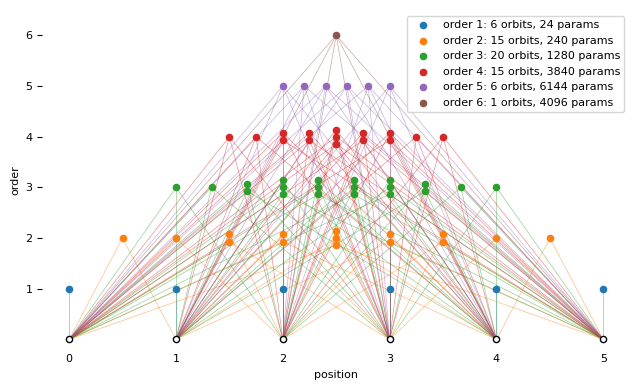

In [12]:
# Create an encoder
encoder = Encoder(L=6, alphabet_name='dna', model_type='allorder')

# View encoder properties
encoder.summarize()

# Visualize the encoder
encoder.visualize(figsize=(6.5, 4))
plt.savefig('fig0_encoder_visualization.png')

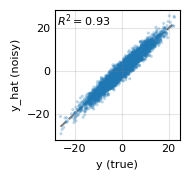

In [7]:
# Create random parameter vector theta
theta = pd.Series(
    data=np.random.normal(size=encoder.n_features),
    index=encoder.user_features
)

# Generate all sequences of length 4
seqs = all_seqs(alphabet=encoder.alphabet, L=encoder.L)
N = len(seqs)

# Compute model predictions for all sequences
y = encoder.score_seqs(theta=theta, seqs=seqs)

# Add noise
sigma = 2
y_hat = y + sigma*np.random.normal(size=N)

# Plot y_hat vs y
plt.figure(figsize=(2, 1.9))
lims = [min(y), max(y)]

# Plot scatter and diagonal line
plt.scatter(y, y_hat, alpha=0.3, s=5, edgecolor='none', color='#1f77b4')
plt.plot(lims, lims, 'k--', alpha=0.5, zorder=-100)

# Add R2 text
r2 = np.corrcoef([y, y_hat])[0,1]**2
plt.text(0.02, 0.98, f'$R^2={r2:.2f}$', fontsize=8,
         transform=plt.gca().transAxes, ha='left', va='top')

# Style axes
plt.xlabel('y (true)', fontsize=8)
plt.ylabel('y_hat (noisy)', fontsize=8)
plt.tick_params(labelsize=8, length=0)

# Set up grid
plt.grid(True, color='gray', alpha=0.2, zorder=-200)

# Style spines
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('black')

plt.tight_layout()
plt.savefig('fig1_model_fit.png')


In [4]:
# Estimate parameters
X = encoder.encode_seqs(seqs)

# Perform least squares regression
theta_hat = np.linalg.lstsq(X, y_hat, rcond=None)[0]

# Convert to Series with same index as original theta
theta_hat = pd.Series(theta_hat, index=encoder.user_features)

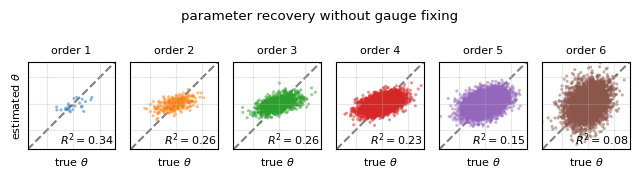

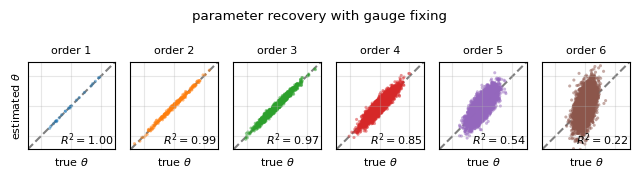

In [6]:

def plot_parameter_recovery(theta, theta_hat, figtitle=None, figsize=(6.5, 2), fontsize=8):
    """
    Plot parameter recovery comparison between true and estimated parameters.
    
    Parameters
    ----------
    theta : pd.Series
        True parameters
    theta_hat : pd.Series 
        Estimated parameters
    encoder : Encoder
        Encoder object used to generate features
    figsize : tuple, optional
        Figure size in inches, default (6.5, 2)
    fontsize : int, optional
        Base font size, default 8
    """
    # Create figure with 6 subplots in a row
    fig, axes = plt.subplots(1, 6, figsize=figsize, sharey=True)

    # Get orders of each feature
    orders = [len(positions) for positions, _ in theta.index]

    # Get overall limits for consistent axes
    all_values = np.concatenate([theta.values, theta_hat.values])
    global_min = np.min(all_values)
    global_max = np.max(all_values)
    lims = [global_min, global_max]

    # Plot each order in separate subplot
    for order in range(1, 7):
        ax = axes[order-1]
        
        # Get indices for this order
        idx = [i for i,o in enumerate(orders) if o == order]
        
        # Plot theta vs theta_hat for this order
        ax.scatter(
            theta.iloc[idx],
            theta_hat.iloc[idx],
            alpha=0.5,
            s=5,
            edgecolor='none',
            color = f'C{order-1}',
            label=f'order {order}'
        )
        
        # Add diagonal line
        ax.plot(lims, lims, 'k--', alpha=0.5, zorder=-100)
        
        # Customize subplot
        ax.set_xlabel(r'true $\theta$', fontsize=fontsize)
        if order == 1:  # Only add y label to leftmost plot
            ax.set_ylabel(r'estimated $\theta$', fontsize=fontsize)
        title = f'order {order}' #\n({len(idx)} params)'
        ax.set_title(title, fontsize=fontsize)
        # Calculate R^2 for this order
        r2 = np.corrcoef(theta.iloc[idx], theta_hat.iloc[idx])[0,1]**2
        ax.text(0.98, 0.02, f'$R^2={r2:.2f}$', fontsize=fontsize, 
                transform=ax.transAxes, ha='right', va='bottom')
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelbottom=False, labelleft=False, size=0)
        
        # Make plot square and set consistent limits
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_aspect('equal')

    plt.tight_layout()
    if figtitle is not None:
        fig.suptitle(figtitle, fontsize=fontsize*1.2)
    
    return fig, axes

# Plot parameter recovery without gauge fixing
plot_parameter_recovery(theta, theta_hat, figtitle='parameter recovery without gauge fixing');
plt.savefig('fig1_parameter_recovery_no_gauge.png')

# Create GaugeFixer object and fix parameters
fixer = GaugeFixer(encoder)
theta_fixed = fixer.fix(theta, gauge="zero-sum")
theta_hat_fixed = fixer.fix(theta_hat, gauge="zero-sum")

# Plot parameter recovery with gauge fixing
plot_parameter_recovery(theta_fixed, theta_hat_fixed, figtitle='parameter recovery with gauge fixing');
plt.savefig('fig1_parameter_recovery_with_gauge.png')
